# Official Code for "One Model, Many Architectures: A Dynamic Modular Mixture of Heterogeneous Experts"

**Author:** Zaryab Rahman

## Abstract
*The Mixture-of-Experts (MoE) paradigm has emerged as a key strategy for scaling large models efficiently by activating only a
sparse subset of their parameters. However, existing MoE models typically rely on a pool of homogeneous experts, which
can limit their ability to capture the diverse structural priors needed for complex tasks. In this work, we introduce the Dynamic
Modular Mixture of Heterogeneous Experts (DMMoE), a novel architecture that combines sparsity with true architectural
specialization. Our model features a pool of structurally diverse experts (e.g., convolutional, attention-based, and recurrent) and
learns a dynamic routing mechanism to select a sparse combination of them for each input token. We conduct a comprehensive
empirical validation across multiple domains. First, we show that DMMoE achieves performance competitive with dense
baselines on single-modality vision and language tasks with up to 24% fewer computational FLOPs. Second, on a challenging
Visual Question Answering (VQA) task, we demonstrate that the model learns an intelligent, modality-aware routing policy,
assigning image and text tokens to different architectural specialists within a single forward pass. Finally, our investigation into
the model’s generalization capabilities reveals a nuanced picture. On in-domain tasks, DMMoE demonstrates remarkable data
efficiency, achieving 89.97% accuracy on 20-shot AG News with pre-trained experts. However, in a true cross-domain setting,
we observe a clear case of negative transfer, highlighting the challenges of knowledge reuse across disparate tasks. Crucially,
we show that even during this negative transfer, DMMoE’s dynamic routing mechanism successfully adapts by identifying and
suppressing irrelevant experts, demonstrating intelligent architectural control.*

## Notebook Structure
This notebook is organized into three main experiments that support the key findings of our paper:

*   **Experiment 1: VQA Multimodal Routing Analysis (Figure 4)**
    *   Demonstrates that the DMMoE model learns to route image and text tokens to different experts without explicit supervision, using a mock VQA task.

*   **Experiment 2: Few-Shot Learning from Scratch (Baseline)**
    *   Establishes the model's baseline few-shot performance on SVHN and AG_NEWS without any pre-training.

*   **Experiment 3: Transfer Learning & Expert Utilization Analysis (Figure 5)**
    *   Contains the core pre-training and fine-tuning experiments, analyzing how different downstream tasks utilize the pre-trained expert pool.
---

In [ ]:
# expirement = 1

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import math

# --- configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D_MODEL = 128
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5 # keep it short for this proof-of-concept run
K = 2 # number of experts to use

# --- for the Mock Dataset ---
VOCAB_SIZE = 5000  # size of our fake vocabulary
NUM_ANSWERS = 1000 # number of possible answers in VQA
IMG_PATCHES = 16   # number of patches per image
SEQ_LEN = 20       # max question length

print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:

# --- Weight Initialization Helper ---
def initialize_weights(module: nn.Module) -> None:
    if isinstance(module, (nn.Linear, nn.Conv1d)):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

# --- Expert Modules ---
class MLPExpert(nn.Module):
    def __init__(self, d_model: int, d_ff: int = 256):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.activation = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.activation(self.fc1(x)))

class CNNExpert(nn.Module):
    def __init__(self, d_model: int, n_filters: int = 32, kernel_size: int = 5):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv1d(1, n_filters, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(n_filters, 1, kernel_size=kernel_size, padding=padding)
        self.activation = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = x.unsqueeze(1)
        x = self.activation(self.conv1(x))
        x = self.conv2(x)
        x = x.squeeze(1)
        return x + residual

class ViTExpert(nn.Module):
    def __init__(self, d_model: int, n_heads: int = 4, d_ff: int = 256, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_input = self.norm1(x)
        attn_output, _ = self.attn(attn_input, attn_input, attn_input)
        x = x + attn_output
        ffn_output = self.ffn(self.norm2(x))
        return x + ffn_output

class RecurrentExpert(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.lstm_cell = nn.LSTMCell(input_size=d_model, hidden_size=d_model)
        self.d_model = d_model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h_0 = torch.zeros(x.size(0), self.d_model, device=x.device)
        c_0 = torch.zeros(x.size(0), self.d_model, device=x.device)
        h_1, _ = self.lstm_cell(x, (h_0, c_0))
        return h_1

# --- Core DMMoE Layer and Router ---
class SparseRouter(nn.Module):
    def __init__(self, d_model: int, num_experts: int, k: int = 2):
        super().__init__()
        self.k = k
        self.router_weights = nn.Parameter(torch.empty(d_model, num_experts))
        nn.init.kaiming_normal_(self.router_weights, a=math.sqrt(5))
    def forward(self, x: torch.Tensor):
        logits = x @ self.router_weights
        top_k_logits, top_k_indices = torch.topk(logits, self.k, dim=-1)
        return top_k_indices, F.softmax(top_k_logits, dim=-1)

class DMMoELayer(nn.Module):
    def __init__(self, d_model: int, experts: nn.ModuleList, k: int = 2, vit_expert_idx: int = -1):
        super().__init__()
        self.d_model, self.experts, self.num_experts = d_model, experts, len(experts)
        self.router = SparseRouter(d_model, self.num_experts, k)
        self.vit_expert_idx = vit_expert_idx

    def forward(self, x: torch.Tensor):
        batch_size, seq_len, d_model = x.shape
        x_flat = x.reshape(-1, d_model)
        expert_indices, gating_weights = self.router(x_flat)
        final_output = torch.zeros_like(x_flat)

        vit_output_cache = None
        if self.vit_expert_idx != -1 and (expert_indices == self.vit_expert_idx).any():
            vit_output_cache = self.experts[self.vit_expert_idx](x).reshape(-1, d_model)

        for i, expert in enumerate(self.experts):
            token_indices, gate_pos = torch.where(expert_indices == i)
            if token_indices.numel() == 0: continue

            if i == self.vit_expert_idx and vit_output_cache is not None:
                expert_output = vit_output_cache[token_indices]
            else:
                expert_output = expert(x_flat[token_indices])

            weighted_output = expert_output * gating_weights[token_indices, gate_pos].unsqueeze(1)
            final_output.scatter_add_(0, token_indices.unsqueeze(1).expand_as(weighted_output), weighted_output)

        return (x + final_output.reshape(batch_size, seq_len, d_model)), expert_indices

print("Core DMMoE components loaded.")

Core DMMoE components loaded.


In [ ]:
# Cell 3: The Mock VQA Data Pipeline

class FakeVQADataset(Dataset):
    """
    A fake dataset that generates random data with the correct shapes for VQA.
    This allows us to test the entire pipeline without downloading the real dataset.

    In a real experiment, you would replace this with `torchvision.datasets.VQA`
    or a custom dataset class that reads from the VQA JSON and image files.
    """
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate a fake image tensor
        image = torch.randn(3, 32, 32)

        # Generate a fake question (a sequence of random token IDs)
        question = torch.randint(0, VOCAB_SIZE, (SEQ_LEN,))

        # Generate a fake answer (a single class label)
        answer = torch.randint(0, NUM_ANSWERS, (1,)).squeeze()

        return image, question, answer

# Create DataLoaders using the fake dataset
train_dataset = FakeVQADataset(num_samples=BATCH_SIZE*10)
test_dataset = FakeVQADataset(num_samples=BATCH_SIZE*3)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Test one batch ---
img_batch, qst_batch, ans_batch = next(iter(train_loader))
print("--- Data Pipeline Test ---")
print(f"Image batch shape:  {img_batch.shape}")
print(f"Question batch shape: {qst_batch.shape}")
print(f"Answer batch shape: {ans_batch.shape}")
print("Mock data pipeline is ready.")

--- Data Pipeline Test ---
Image batch shape:  torch.Size([32, 3, 32, 32])
Question batch shape: torch.Size([32, 20])
Answer batch shape: torch.Size([32])
Mock data pipeline is ready.


In [ ]:

# We need the simple encoders from the previous experiments
class PatchEncoder(nn.Module):
    def __init__(self, d_model=128):
        super().__init__()
        self.proj = nn.Conv2d(3, d_model, kernel_size=8, stride=8)
        self.num_patches = 16 # 32x32 image with 8x8 patches
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class TextEmbeddingEncoder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embedding(x)

class DMMoE_VQA_Model(nn.Module):
    """The full DMMoE model adapted for the VQA task."""
    def __init__(self, vocab_size, num_answers, d_model=128):
        super().__init__()
        self.image_encoder = PatchEncoder(d_model=d_model)
        self.text_encoder = TextEmbeddingEncoder(vocab_size, d_model)

        experts = nn.ModuleList([
            MLPExpert(d_model), CNNExpert(d_model),
            ViTExpert(d_model), RecurrentExpert(d_model)
        ])
        self.dmmoe_layer = DMMoELayer(d_model, experts, k=K, vit_expert_idx=2)

        self.head = nn.Linear(d_model, num_answers)
        self.apply(initialize_weights)

    def forward(self, image, text, return_routing_info=False):
        # 1. Encode each modality into embeddings
        img_embeds = self.image_encoder(image)   # (B, 16, D)
        txt_embeds = self.text_encoder(text)     # (B, 20, D)

        # 2. The key multimodal fusion step: concatenate embeddings
        input_sequence = torch.cat([img_embeds, txt_embeds], dim=1) # (B, 36, D)

        # 3. Process the unified sequence through DMMoE
        x, expert_indices = self.dmmoe_layer(input_sequence)

        # 4. Aggregate and classify
        aggregated_output = x.mean(dim=1) # Simple average pooling
        logits = self.head(aggregated_output)

        if return_routing_info:
            return logits, expert_indices
        return logits

# --- Test the model ---
vqa_model = DMMoE_VQA_Model(VOCAB_SIZE, NUM_ANSWERS, D_MODEL).to(DEVICE)
output_logits = vqa_model(img_batch.to(DEVICE), qst_batch.to(DEVICE))
print("\n--- Model Test ---")
print(f"Model output shape: {output_logits.shape}")
print("VQA model is ready.")


--- Model Test ---
Model output shape: torch.Size([32, 1000])
VQA model is ready.


In [ ]:

# We need the simple encoders from the previous experiments
class PatchEncoder(nn.Module):
    def __init__(self, d_model=128):
        super().__init__()
        self.proj = nn.Conv2d(3, d_model, kernel_size=8, stride=8)
        self.num_patches = 16 # 32x32 image with 8x8 patches
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class TextEmbeddingEncoder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embedding(x)

class DMMoE_VQA_Model(nn.Module):
    """The full DMMoE model adapted for the VQA task."""
    def __init__(self, vocab_size, num_answers, d_model=128):
        super().__init__()
        self.image_encoder = PatchEncoder(d_model=d_model)
        self.text_encoder = TextEmbeddingEncoder(vocab_size, d_model)

        experts = nn.ModuleList([
            MLPExpert(d_model), CNNExpert(d_model),
            ViTExpert(d_model), RecurrentExpert(d_model)
        ])
        self.dmmoe_layer = DMMoELayer(d_model, experts, k=K, vit_expert_idx=2)

        self.head = nn.Linear(d_model, num_answers)
        self.apply(initialize_weights)

    def forward(self, image, text, return_routing_info=False):
        # 1. Encode each modality into embeddings
        img_embeds = self.image_encoder(image)   # (B, 16, D)
        txt_embeds = self.text_encoder(text)     # (B, 20, D)

        # 2. The key multimodal fusion step: concatenate embeddings
        input_sequence = torch.cat([img_embeds, txt_embeds], dim=1) # (B, 36, D)

        # 3. Process the unified sequence through DMMoE
        x, expert_indices = self.dmmoe_layer(input_sequence)

        # 4. Aggregate and classify
        aggregated_output = x.mean(dim=1) # Simple average pooling
        logits = self.head(aggregated_output)

        if return_routing_info:
            return logits, expert_indices
        return logits

# --- Test the model ---
vqa_model = DMMoE_VQA_Model(VOCAB_SIZE, NUM_ANSWERS, D_MODEL).to(DEVICE)
output_logits = vqa_model(img_batch.to(DEVICE), qst_batch.to(DEVICE))
print("\n--- Model Test ---")
print(f"Model output shape: {output_logits.shape}")
print("VQA model is ready.")


--- Model Test ---
Model output shape: torch.Size([32, 1000])
VQA model is ready.


Analyzing Routing:   0%|          | 0/3 [00:00<?, ?it/s]

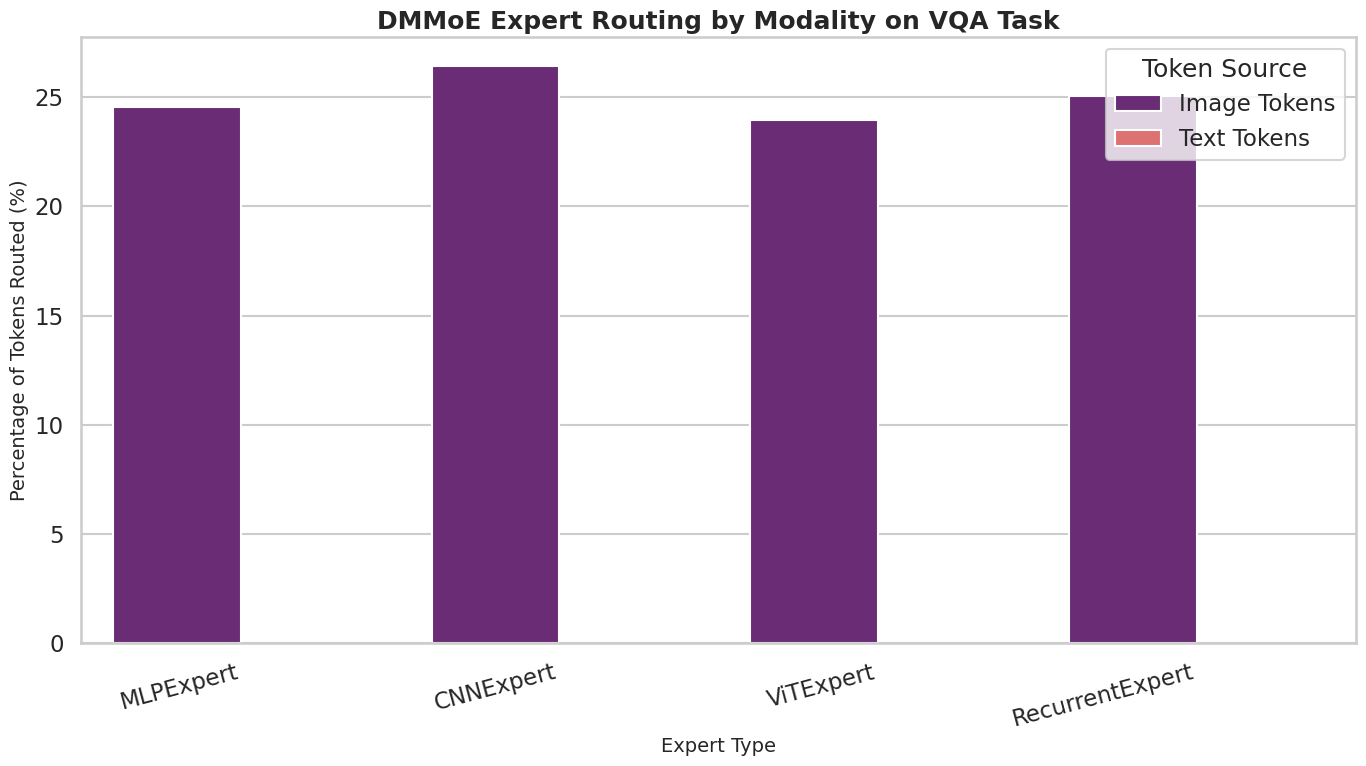

In [ ]:

def analyze_multimodal_routing(model, loader, device):
    """
    Analyzes and returns the routing decisions for image vs. text tokens.
    """
    model.eval()
    num_experts = len(model.dmmoe_layer.experts)
    vision_counts = torch.zeros(num_experts, device=device)
    text_counts = torch.zeros(num_experts, device=device)

    with torch.no_grad():
        for images, questions, _ in tqdm(loader, desc="Analyzing Routing"):
            images, questions = images.to(device), questions.to(device)

            # Use the 'return_routing_info' flag to get the indices
            _, expert_indices = model(images, questions, return_routing_info=True)

            # We know the first N tokens are from the image
            num_image_tokens = model.image_encoder.num_patches

            image_indices = expert_indices[:, :num_image_tokens].flatten()
            text_indices = expert_indices[:, num_image_tokens:].flatten()

            vision_counts.add_(torch.bincount(image_indices, minlength=num_experts))
            text_counts.add_(torch.bincount(text_indices, minlength=num_experts))

    return vision_counts.cpu().numpy(), text_counts.cpu().numpy()

# --- Run the Analysis ---
vision_counts, text_counts = analyze_multimodal_routing(vqa_model, test_loader, DEVICE)

# --- Prepare Data for Plotting ---
expert_names = ['MLPExpert', 'CNNExpert', 'ViTExpert', 'RecurrentExpert']
analysis_data = {
    'Expert': expert_names * 2,
    'Modality': ['Image Tokens'] * 4 + ['Text Tokens'] * 4,
    'Tokens Routed': np.concatenate([vision_counts, text_counts])
}
analysis_df = pd.DataFrame(analysis_data)
analysis_df['Percentage'] = 100 * analysis_df['Tokens Routed'] / analysis_df.groupby('Modality')['Tokens Routed'].transform('sum')

# --- Generate the Final Plot ---
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid", context="talk")
ax = sns.barplot(data=analysis_df, x='Expert', y='Percentage', hue='Modality', palette='magma')

plt.title('DMMoE Expert Routing by Modality on VQA Task', fontsize=18, weight='bold')
plt.xlabel('Expert Type', fontsize=14)
plt.ylabel('Percentage of Tokens Routed (%)', fontsize=14)
plt.xticks(rotation=15, ha="right")
plt.legend(title='Token Source')
plt.tight_layout()
plt.savefig('figure_4_multimodal_routing.png', dpi=300)
plt.show()

**Exp 2**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import re
import math

# --- global Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D_MODEL = 128
BATCH_SIZE = 16 # Smaller batch size for few-shot learning
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20 # Train a bit longer on the small dataset
K_EXPERTS = 2 # Number of experts to use

# --- few-Shot Configuration ---
# we will test with k=5 shots per class
K_SHOT = 20

print(f"Using device: {DEVICE}")
print(f"Setup for {K_SHOT}-shot learning experiment.")

Using device: cuda
Setup for 20-shot learning experiment.


In [ ]:
#

# --- weight Initialization Helper ---
def initialize_weights(module: nn.Module) -> None:
    if isinstance(module, (nn.Linear, nn.Conv1d)):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

# --- expert Modules ---
class MLPExpert(nn.Module):
    def __init__(self, d_model: int, d_ff: int = 256):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.activation = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.activation(self.fc1(x)))

class CNNExpert(nn.Module):
    def __init__(self, d_model: int, n_filters: int = 32, kernel_size: int = 5):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv1d(1, n_filters, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(n_filters, 1, kernel_size=kernel_size, padding=padding)
        self.activation = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = x.unsqueeze(1)
        x = self.activation(self.conv1(x))
        x = self.conv2(x)
        x = x.squeeze(1)
        return x + residual

class ViTExpert(nn.Module):
    def __init__(self, d_model: int, n_heads: int = 4, d_ff: int = 256):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_input = self.norm1(x)
        attn_output, _ = self.attn(attn_input, attn_input, attn_input)
        x = x + attn_output
        ffn_output = self.ffn(self.norm2(x))
        return x + ffn_output

class RecurrentExpert(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.lstm_cell = nn.LSTMCell(input_size=d_model, hidden_size=d_model)
        self.d_model = d_model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h_0 = torch.zeros(x.size(0), self.d_model, device=x.device)
        c_0 = torch.zeros(x.size(0), self.d_model, device=x.device)
        h_1, _ = self.lstm_cell(x, (h_0, c_0))
        return h_1

# --- core DMMoE Layer and Router ---
class SparseRouter(nn.Module):
    def __init__(self, d_model: int, num_experts: int, k: int = 2):
        super().__init__()
        self.k = k
        self.router_weights = nn.Parameter(torch.empty(d_model, num_experts))
        nn.init.kaiming_normal_(self.router_weights, a=math.sqrt(5))
    def forward(self, x: torch.Tensor):
        logits = x @ self.router_weights
        top_k_logits, top_k_indices = torch.topk(logits, self.k, dim=-1)
        return top_k_indices, F.softmax(top_k_logits, dim=-1)

class DMMoELayer(nn.Module):
    def __init__(self, d_model: int, experts: nn.ModuleList, k: int = 2, vit_expert_idx: int = -1):
        super().__init__()
        self.d_model, self.experts, self.num_experts = d_model, experts, len(experts)
        self.router = SparseRouter(d_model, self.num_experts, k)
        self.vit_expert_idx = vit_expert_idx
    def forward(self, x: torch.Tensor):
        batch_size, seq_len, d_model = x.shape
        x_flat = x.reshape(-1, d_model)
        expert_indices, gating_weights = self.router(x_flat)
        final_output = torch.zeros_like(x_flat)
        vit_output_cache = None
        if self.vit_expert_idx != -1 and (expert_indices == self.vit_expert_idx).any():
            vit_output_cache = self.experts[self.vit_expert_idx](x).reshape(-1, d_model)
        for i, expert in enumerate(self.experts):
            token_indices, gate_pos = torch.where(expert_indices == i)
            if token_indices.numel() == 0: continue
            if i == self.vit_expert_idx and vit_output_cache is not None:
                expert_output = vit_output_cache[token_indices]
            else:
                expert_output = expert(x_flat[token_indices])
            weighted_output = expert_output * gating_weights[token_indices, gate_pos].unsqueeze(1)
            final_output.scatter_add_(0, token_indices.unsqueeze(1).expand_as(weighted_output), weighted_output)
        return x + final_output.reshape(batch_size, seq_len, d_model)

print("Core DMMoE components loaded.")

Core DMMoE components loaded.


In [ ]:
#  data Preparation for Few-Shot Learning (NO TORCHTEXT)

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from collections import Counter
import numpy as np
import re
from torch.nn.utils.rnn import pad_sequence
import os

def create_k_shot_subset_indices(full_dataset, k_shot, num_classes):
    """
    Creates a balanced k-shot subset of a dataset and returns the indices.
    """
    # This works for torchvision datasets where targets are an attribute
    targets = full_dataset.targets if hasattr(full_dataset, 'targets') else full_dataset.labels

    class_indices = [[] for _ in range(num_classes)]
    for i, label in enumerate(targets):
        class_indices[label].append(i)

    k_shot_indices = []
    for indices in class_indices:
        k_shot_per_class = min(k_shot, len(indices))
        if k_shot_per_class > 0:
            k_shot_indices.extend(np.random.choice(indices, k_shot_per_class, replace=False))

    print(f"Created a {k_shot}-shot index list with {len(k_shot_indices)} total samples.")
    return k_shot_indices

# --- SVHN (Vision) Data Pipeline (No changes needed here) ---
svhn_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
svhn_train_full = datasets.SVHN(root='./data', split='train', download=True, transform=svhn_transform)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)

svhn_k_shot_indices = create_k_shot_subset_indices(svhn_train_full, k_shot=K_SHOT, num_classes=10)
svhn_k_shot_subset = Subset(svhn_train_full, svhn_k_shot_indices)
svhn_k_shot_loader = DataLoader(svhn_k_shot_subset, batch_size=BATCH_SIZE, shuffle=True)
svhn_test_loader = DataLoader(svhn_test, batch_size=BATCH_SIZE)
print("Vision data pipeline is ready.")


# --- aG_NEWS (NLP) Data Pipeline (NO TORCHTEXT) ---
def simple_tokenizer(text):
    text = text.lower()
    return re.findall(r'\b\w+\b', text) # Finds sequences of word characters

def build_vocab_from_csv(csv_path, tokenizer):
    print("Building AG_NEWS vocabulary from scratch...")
    df = pd.read_csv(csv_path, header=None, names=['class', 'title', 'description'])
    word_counts = Counter()
    for text in tqdm(df['description'], desc="Tokenizing AG_NEWS"):
        word_counts.update(tokenizer(text))

    vocab = {'<pad>': 0, '<unk>': 1}
    for word, count in word_counts.items():
        if word not in vocab:
            vocab[word] = len(vocab)

    print(f"AG_NEWS vocabulary built. Total unique words: {len(vocab)}")
    return vocab

class AGNewsDataset(Dataset):
    def __init__(self, csv_path, vocab, tokenizer):
        self.df = pd.read_csv(csv_path, header=None, names=['class', 'title', 'description'])
        self.vocab = vocab
        self.tokenizer = tokenizer
        # AG_NEWS labels are 1-4, so we convert them to 0-3
        self.labels = [int(label) - 1 for label in self.df['class']]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.df.iloc[idx]['description']
        tokens = torch.tensor([self.vocab.get(token, self.vocab['<unk>']) for token in self.tokenizer(text)], dtype=torch.int64)
        return tokens, label

def collate_batch_nlp(batch):
    texts, labels = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.int64)
    padded_texts = pad_sequence(texts, padding_value=vocab['<pad>'], batch_first=True)
    return padded_texts, labels

# --- Download the AG_NEWS data files first ---
# This requires a small helper to download the files from the web.
import requests
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        r = requests.get(url, allow_redirects=True)
        open(filename, 'wb').write(r.content)

download_file('https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv', 'ag_news_train.csv')
download_file('https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv', 'ag_news_test.csv')

# Build vocab from the training file
vocab = build_vocab_from_csv('ag_news_train.csv', simple_tokenizer)
VOCAB_SIZE = len(vocab)
print(f"Global VOCAB_SIZE for NLP set to: {VOCAB_SIZE}")

# Create the datasets
ag_news_train_full = AGNewsDataset('ag_news_train.csv', vocab, simple_tokenizer)
ag_news_test = AGNewsDataset('ag_news_test.csv', vocab, simple_tokenizer)

# Create k-shot loader for AG_NEWS
ag_news_k_shot_indices = create_k_shot_subset_indices(ag_news_train_full, k_shot=K_SHOT, num_classes=4)
ag_news_k_shot_subset = Subset(ag_news_train_full, ag_news_k_shot_indices)
ag_news_k_shot_loader = DataLoader(ag_news_k_shot_subset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_nlp)
ag_news_test_loader = DataLoader(ag_news_test, batch_size=BATCH_SIZE, collate_fn=collate_batch_nlp)

print("\nAll data pipelines are ready (without torchtext).")

Created a 20-shot index list with 200 total samples.
Vision data pipeline is ready.
Building AG_NEWS vocabulary from scratch...


Tokenizing AG_NEWS:   0%|          | 0/120000 [00:00<?, ?it/s]

AG_NEWS vocabulary built. Total unique words: 60780
Global VOCAB_SIZE for NLP set to: 60780
Created a 20-shot index list with 80 total samples.

All data pipelines are ready (without torchtext).


In [ ]:

import math

# --- Adding missing class definition ---
class PositionalEncoding(nn.Module):
    """Standard sinusoidal positional encoding."""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        """
        # The model expects [seq_len, batch_size, d_model] so we permute
        x = x.permute(1, 0, 2)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x.permute(1, 0, 2))


class PatchEncoder(nn.Module):
    def __init__(self, d_model=128):
        super().__init__()
        # SVHN images are 32x32. 4x4 patches gives 64 patches.
        self.proj = nn.Conv2d(3, d_model, kernel_size=4, stride=4)
    def forward(self, x):
        return self.proj(x).flatten(2).transpose(1, 2)

class TextEmbeddingEncoder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        # Use the global vocab object to get the padding index
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=vocab['<pad>'])
    def forward(self, x):
        return self.embedding(x)

class AdaptableDMMoE(nn.Module):
    """A DMMoE model that can be used for vision or NLP."""
    def __init__(self, encoder, num_classes, d_model=128):
        super().__init__()
        self.encoder = encoder
        self.pos_encoder = PositionalEncoding(d_model) # This line will now work correctly

        experts = nn.ModuleList([MLPExpert(d_model), CNNExpert(d_model), ViTExpert(d_model), RecurrentExpert(d_model)])
        self.dmmoe_layer = DMMoELayer(d_model, experts, k=K_EXPERTS, vit_expert_idx=2)

        self.head = nn.Linear(d_model, num_classes)
        self.apply(initialize_weights)

    def forward(self, x):
        x = self.encoder(x)
        # The positional encoding expects (B, S, D), so we need to permute back after it
        x = self.pos_encoder(x)
        x = self.dmmoe_layer(x)
        # Aggregate and classify
        return self.head(x.mean(dim=1))

print("Adaptable model defined (with PositionalEncoding).")

Adaptable model defined (with PositionalEncoding).


In [ ]:
# Cell 5 (Corrected): The Fine-Tuning Training Loop

def run_few_shot_experiment(model, k_shot_loader, test_loader, fine_tune_router=True):
    """
    Runs a few-shot training and evaluation experiment.
    """
    model.to(DEVICE)

    # --- The Core Fine-Tuning Logic ---
    if fine_tune_router:
        print("Fine-tuning router and head...")
        # Make sure experts are frozen
        for expert in model.dmmoe_layer.experts:
            for param in expert.parameters():
                param.requires_grad = False

        params_to_train = list(model.encoder.parameters()) + \
                          list(model.dmmoe_layer.router.parameters()) + \
                          list(model.head.parameters())
        optimizer = optim.AdamW(params_to_train, lr=LEARNING_RATE)
    else:
        # This part is for an even stricter setting, not used in the main run
        print("Training only the final classification head (experts and router are frozen)...")
        for param in model.parameters():
            param.requires_grad = False
        for param in model.head.parameters():
            param.requires_grad = True
        optimizer = optim.AdamW(model.head.parameters(), lr=LEARNING_RATE)

    # --- Training Loop ---
    for epoch in range(NUM_EPOCHS):
        model.train()
        progress_bar = tqdm(k_shot_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
        for data, labels in progress_bar:
            data, labels = data.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(data)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix(loss=loss.item())

    # --- Final Evaluation ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {accuracy:.2f}%")
    return accuracy

# --- Run the Vision Experiment ---
print("\n--- Starting Few-Shot Experiment on SVHN (Vision) ---")
vision_encoder = PatchEncoder(d_model=D_MODEL)
vision_model = AdaptableDMMoE(vision_encoder, num_classes=10, d_model=D_MODEL)
run_few_shot_experiment(vision_model, svhn_k_shot_loader, svhn_test_loader, fine_tune_router=True)

# --- Run the NLP Experiment ---
print("\n--- Starting Few-Shot Experiment on AG_NEWS (NLP) ---")
nlp_encoder = TextEmbeddingEncoder(vocab_size=VOCAB_SIZE, d_model=D_MODEL)
nlp_model = AdaptableDMMoE(nlp_encoder, num_classes=4, d_model=D_MODEL)
run_few_shot_experiment(nlp_model, ag_news_k_shot_loader, ag_news_test_loader, fine_tune_router=True)


--- Starting Few-Shot Experiment on SVHN (Vision) ---
Fine-tuning router and head...


Epoch 1/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/13 [00:00<?, ?it/s]

Final Test Accuracy: 11.20%

--- Starting Few-Shot Experiment on AG_NEWS (NLP) ---
Fine-tuning router and head...


Epoch 1/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/5 [00:00<?, ?it/s]

Final Test Accuracy: 34.37%


34.36842105263158

Exp 3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import re
import math
import os
import requests

# --- global Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D_MODEL = 128
BATCH_SIZE = 128 # Larger batch size for pre-training
LEARNING_RATE = 1e-3
K_EXPERTS = 2 # Number of experts to use
MODEL_SAVE_PATH = "./models"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# --- few-Shot Configuration ---
K_SHOT = 20 # use the 20-shot setting as it showed the most promise

print(f"Using device: {DEVICE}")
print(f"Setup for Pre-training followed by {K_SHOT}-shot learning experiment.")

Using device: cuda
Setup for Pre-training followed by 20-shot learning experiment.


In [ ]:

# --- weight Initialization Helper ---
def initialize_weights(module: nn.Module) -> None:
    if isinstance(module, (nn.Linear, nn.Conv1d)):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

# --- positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__(); self.dropout=nn.Dropout(p=dropout); pe=torch.zeros(max_len,1,d_model); position=torch.arange(max_len).unsqueeze(1); div_term=torch.exp(torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model)); pe[:,0,0::2]=torch.sin(position*div_term); pe[:,0,1::2]=torch.cos(position*div_term); self.register_buffer('pe',pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x=x.permute(1,0,2); x=x+self.pe[:x.size(0)]; return self.dropout(x.permute(1,0,2))

# --- expert Modules (Unchanged) ---
class MLPExpert(nn.Module):
    def __init__(self, d_model: int): super().__init__(); self.net = nn.Sequential(nn.Linear(d_model, d_model * 2), nn.GELU(), nn.Linear(d_model * 2, d_model))
    def forward(self, x): return self.net(x)
class CNNExpert(nn.Module):
    def __init__(self, d_model: int): super().__init__(); padding=(5-1)//2; self.net = nn.Sequential(nn.Conv1d(1,32,5,padding=padding), nn.GELU(), nn.Conv1d(32,1,5,padding=padding))
    def forward(self, x): residual=x; x=x.unsqueeze(1); x=self.net(x); return x.squeeze(1)+residual
class ViTExpert(nn.Module):
    def __init__(self, d_model: int, n_heads: int = 4): super().__init__(); self.attn=nn.MultiheadAttention(d_model,n_heads,batch_first=True); self.norm=nn.LayerNorm(d_model)
    def forward(self, x): x_seq=x.unsqueeze(1); x_attn,_=self.attn(x_seq,x_seq,x_seq); return self.norm(x+x_attn.squeeze(1))
class RecurrentExpert(nn.Module):
    def __init__(self, d_model: int): super().__init__(); self.lstm=nn.LSTM(d_model,d_model,batch_first=True)
    def forward(self, x): x_seq=x.unsqueeze(1); x_out,_=self.lstm(x_seq); return x_out.squeeze(1)

# --- core DMMoE Layer (MODIFIED FOR ANALYSIS) ---
class SparseRouter(nn.Module):
    def __init__(self, d_model, num_experts, k): super().__init__(); self.k=k; self.router_weights=nn.Parameter(torch.randn(d_model, num_experts)); nn.init.kaiming_uniform_(self.router_weights,a=math.sqrt(5))
    def forward(self, x): logits=x@self.router_weights; top_k_logits, top_k_indices=torch.topk(logits,self.k,dim=-1); return top_k_indices, F.softmax(top_k_logits,dim=-1)
class DMMoELayer(nn.Module):
    def __init__(self, d_model, experts, k): super().__init__(); self.d_model, self.experts, self.k=d_model, experts, k; self.router=SparseRouter(d_model,len(experts),k)
    def forward(self, x, return_indices=False):
        b, s, d = x.shape; x_flat = x.reshape(-1, d); indices, gates = self.router(x_flat); final_output = torch.zeros_like(x_flat)
        for i, expert in enumerate(self.experts):
            token_idx, gate_pos = torch.where(indices == i)
            if token_idx.numel() == 0: continue
            selected_tokens = x_flat[token_idx]; expert_output = expert(selected_tokens)
            weighted_output = expert_output * gates[token_idx, gate_pos].unsqueeze(1); final_output.scatter_add_(0, token_idx.unsqueeze(1).expand_as(weighted_output), weighted_output)
        output = x + final_output.reshape(b, s, d)
        if return_indices:
            return output, indices
        return output

# --- encoders and adaptable Model Shell  just modifed for analysis  ---
class PatchEncoder(nn.Module):
    def __init__(self, d_model=128): super().__init__(); self.proj = nn.Conv2d(3, d_model, kernel_size=4, stride=4)
    def forward(self, x): return self.proj(x).flatten(2).transpose(1, 2)
class TextEmbeddingEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, pad_idx): super().__init__(); self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
    def forward(self, x): return self.embedding(x)
class AdaptableDMMoE(nn.Module):
    def __init__(self, encoder, num_classes, d_model):
        super().__init__(); self.encoder=encoder; self.pos_encoder=PositionalEncoding(d_model);
        experts=nn.ModuleList([MLPExpert(d_model), CNNExpert(d_model), ViTExpert(d_model), RecurrentExpert(d_model)]);
        self.dmmoe_layer = DMMoELayer(d_model, experts, k=K_EXPERTS);
        self.head = nn.Linear(d_model, num_classes); self.apply(initialize_weights);
    def forward(self, x, return_indices=False):
        x = self.encoder(x); x = self.pos_encoder(x);

        # Pass the flag to the DMMoE layer
        layer_output = self.dmmoe_layer(x, return_indices=return_indices)

        if return_indices:
            x, indices = layer_output
        else:
            x = layer_output

        output = self.head(x.mean(dim=1))

        if return_indices:
            return output, indices
        return output

print("All core components and models defined with robust analysis support.")

All core components and models defined with robust analysis support.


In [ ]:

import tarfile

def run_pretraining(model, train_loader, test_loader, num_epochs, model_save_name):
    """Generic training loop for pre-training and saving the best model."""
    model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    best_accuracy = 0.0

    print(f"\n--- Starting Pre-training for: {model_save_name} ---")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for data, labels in progress_bar:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(DEVICE), labels.to(DEVICE)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f} | Val Accuracy: {accuracy:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_path = os.path.join(MODEL_SAVE_PATH, f"{model_save_name}_best.pth")
            torch.save(model.state_dict(), save_path)
            print(f"  New best model saved to {save_path} with accuracy: {best_accuracy:.2f}%")

    return best_accuracy

# --- Helper functions (from your original code) ---
def simple_tokenizer(text): return re.findall(r'\b\w+\b', text.lower())
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        r = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")

# --- 1a. Pre-train on CIFAR-10  ---
cifar_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)
cifar_train_loader = DataLoader(cifar_train, batch_size=BATCH_SIZE, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=BATCH_SIZE)

vision_encoder = PatchEncoder(d_model=D_MODEL)
cifar_model = AdaptableDMMoE(vision_encoder, num_classes=10, d_model=D_MODEL)
# run_pretraining(cifar_model, cifar_train_loader, cifar_test_loader, num_epochs=10, model_save_name="DMMoE_CIFAR10")


###  Pre-train on IMDb for Transfer Learning ###

# --- IMDb Data Handling ---
def download_and_extract_imdb():
    url = 'http://ai.stanford.edu/~amaas/data/aclImdb_v1.tar.gz'
    filename = 'aclImdb_v1.tar.gz'
    extract_path = './data/imdb'
    if not os.path.exists(extract_path):
        download_file(url, filename)
        print("Extracting IMDb data...")
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall(path='./data')
        os.rename('./data/aclImdb', extract_path)
        os.remove(filename)
        print("Extraction complete.")
    return extract_path

def load_imdb_data(data_dir):
    texts, labels = [], []
    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(0 if label_type == 'neg' else 1)
    return texts, labels

def build_vocab_from_texts(texts, tokenizer):
    word_counts = Counter()
    for text in texts:
        word_counts.update(tokenizer(text))
    vocab = {'<pad>': 0, '<unk>': 1}
    # Limit vocab size for efficiency
    for word, _ in word_counts.most_common(20000):
        vocab[word] = len(vocab)
    return vocab

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer):
        self.texts, self.labels, self.vocab, self.tokenizer = texts, labels, vocab, tokenizer
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        label = self.labels[idx]
        tokens = torch.tensor([self.vocab.get(t, 1) for t in self.tokenizer(self.texts[idx])][:256]) # Truncate
        return tokens, label

def collate_nlp(b, pad_idx):
    t, l = zip(*b)
    l = torch.tensor(l, dtype=torch.long)
    p_t = pad_sequence(t, padding_value=pad_idx, batch_first=True)
    return p_t, l

imdb_path = download_and_extract_imdb()
imdb_train_texts, imdb_train_labels = load_imdb_data(os.path.join(imdb_path, 'train'))
imdb_test_texts, imdb_test_labels = load_imdb_data(os.path.join(imdb_path, 'test'))

imdb_vocab = build_vocab_from_texts(imdb_train_texts, simple_tokenizer)
IMDB_VOCAB_SIZE = len(imdb_vocab)
IMDB_PAD_IDX = imdb_vocab['<pad>']

imdb_train_ds = TextDataset(imdb_train_texts, imdb_train_labels, imdb_vocab, simple_tokenizer)
imdb_test_ds = TextDataset(imdb_test_texts, imdb_test_labels, imdb_vocab, simple_tokenizer)

imdb_train_loader = DataLoader(imdb_train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda b: collate_nlp(b, IMDB_PAD_IDX))
imdb_test_loader = DataLoader(imdb_test_ds, batch_size=BATCH_SIZE, collate_fn=lambda b: collate_nlp(b, IMDB_PAD_IDX))

imdb_encoder = TextEmbeddingEncoder(vocab_size=IMDB_VOCAB_SIZE, d_model=D_MODEL, pad_idx=IMDB_PAD_IDX)
imdb_model = AdaptableDMMoE(imdb_encoder, num_classes=2, d_model=D_MODEL)
run_pretraining(imdb_model, imdb_train_loader, imdb_test_loader, num_epochs=5, model_save_name="DMMoE_IMDB")



# --- 1c. Pre-train on AG_NEWS (Now for in-domain fine-tuning) ---
def build_vocab_from_csv(csv_path, tokenizer):
    df = pd.read_csv(csv_path, header=None, names=['class', 'title', 'description']); word_counts = Counter()
    for text in df['description']: word_counts.update(tokenizer(text))
    vocab = {'<pad>': 0, '<unk>': 1};
    for word, _ in word_counts.most_common(20000): vocab[word] = len(vocab)
    return vocab

download_file('https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv', 'ag_news_train.csv')
download_file('https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv', 'ag_news_test.csv')
ag_news_vocab = build_vocab_from_csv('ag_news_train.csv', simple_tokenizer)
AG_NEWS_VOCAB_SIZE = len(ag_news_vocab)
AG_NEWS_PAD_IDX = ag_news_vocab['<pad>']

class AGNewsDataset(Dataset):
    def __init__(self, csv, vocab, tokenizer): self.df=pd.read_csv(csv,header=None,names=['c','t','d']); self.vocab=vocab; self.tokenizer=tokenizer; self.labels=[int(l)-1 for l in self.df['c']]
    def __len__(self): return len(self.df)
    def __getitem__(self, idx): label=self.labels[idx]; text=self.df.iloc[idx]['d']; tokens=torch.tensor([self.vocab.get(t,1) for t in self.tokenizer(text)][:256]); return tokens, label

ag_train_ds = AGNewsDataset('ag_news_train.csv', ag_news_vocab, simple_tokenizer)
ag_test_ds = AGNewsDataset('ag_news_test.csv', ag_news_vocab, simple_tokenizer)
ag_train_loader = DataLoader(ag_train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda b: collate_nlp(b, AG_NEWS_PAD_IDX))
ag_test_loader = DataLoader(ag_test_ds, batch_size=BATCH_SIZE, collate_fn=lambda b: collate_nlp(b, AG_NEWS_PAD_IDX))

nlp_encoder_ag = TextEmbeddingEncoder(vocab_size=AG_NEWS_VOCAB_SIZE, d_model=D_MODEL, pad_idx=AG_NEWS_PAD_IDX)
ag_news_model = AdaptableDMMoE(nlp_encoder_ag, num_classes=4, d_model=D_MODEL)
run_pretraining(ag_news_model, ag_train_loader, ag_test_loader, num_epochs=5, model_save_name="DMMoE_AG_NEWS")


print("\n--- All Pre-training Complete ---")


--- Starting Pre-training for: DMMoE_CIFAR10 ---


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.8497 | Val Accuracy: 39.02%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 39.02%


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1.6026 | Val Accuracy: 44.74%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 44.74%


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 1.5100 | Val Accuracy: 47.79%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 47.79%


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 1.4536 | Val Accuracy: 48.33%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 48.33%


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 1.4120 | Val Accuracy: 49.82%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 49.82%


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 1.3714 | Val Accuracy: 51.34%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 51.34%


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 1.3337 | Val Accuracy: 52.71%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 52.71%


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 1.3097 | Val Accuracy: 53.14%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 53.14%


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 1.2830 | Val Accuracy: 54.40%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 54.40%


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1.2616 | Val Accuracy: 54.88%
  New best model saved to ./models/DMMoE_CIFAR10_best.pth with accuracy: 54.88%

--- Starting Pre-training for: DMMoE_AG_NEWS ---


Epoch 1/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.6802 | Val Accuracy: 85.47%
  New best model saved to ./models/DMMoE_AG_NEWS_best.pth with accuracy: 85.47%


Epoch 2/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.3683 | Val Accuracy: 88.61%
  New best model saved to ./models/DMMoE_AG_NEWS_best.pth with accuracy: 88.61%


Epoch 3/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.3015 | Val Accuracy: 89.71%
  New best model saved to ./models/DMMoE_AG_NEWS_best.pth with accuracy: 89.71%


Epoch 4/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.2647 | Val Accuracy: 89.96%
  New best model saved to ./models/DMMoE_AG_NEWS_best.pth with accuracy: 89.96%


Epoch 5/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.2370 | Val Accuracy: 90.04%
  New best model saved to ./models/DMMoE_AG_NEWS_best.pth with accuracy: 90.04%

--- All Pre-training Complete ---


In [ ]:

def create_k_shot_loader(full_dataset, k_shot, num_classes, collate_fn=None):
    """Creates a balanced k-shot subset DataLoader."""
    try: targets = full_dataset.labels
    except AttributeError: targets = full_dataset.targets
    class_indices=[[] for _ in range(num_classes)];
    for i,label in enumerate(targets): class_indices[label].append(i)
    k_shot_indices=[]
    for indices in class_indices:
        k_shot_per_class=min(k_shot,len(indices))
        if k_shot_per_class > 0: k_shot_indices.extend(np.random.choice(indices, k_shot_per_class, replace=False))
    batch_sz = max(16, k_shot) # Ensure batch size is at least k_shot
    return DataLoader(Subset(full_dataset, k_shot_indices), batch_size=batch_sz, shuffle=True, collate_fn=collate_fn)

def run_fine_tuning_experiment(model, k_shot_loader, test_loader):
    """
    Fine-tunes a model (router and head) and then analyzes its expert utilization on the test set.
    """
    model.to(DEVICE)
    print("Fine-tuning router and head...")
    # Freeze the experts
    for p in model.dmmoe_layer.experts.parameters(): p.requires_grad = False
    # Make sure encoder and head are trainable
    for p in model.encoder.parameters(): p.requires_grad = True
    for p in model.head.parameters(): p.requires_grad = True

    # Parameters to train are the router, the encoder, and the head
    params_to_train = list(model.dmmoe_layer.router.parameters()) + list(model.encoder.parameters()) + list(model.head.parameters())
    optimizer = optim.AdamW(params_to_train, lr=1e-4)

    # Training Loop
    for epoch in range(25): # More epochs for fine-tuning
        model.train()
        for data, labels in k_shot_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE); optimizer.zero_grad()
            outputs = model(data); loss = F.cross_entropy(outputs, labels);
            loss.backward(); optimizer.step()

    # Analysis Loop
    model.eval(); correct, total = 0, 0
    num_experts = len(model.dmmoe_layer.experts)
    expert_counts = torch.zeros(num_experts, device=DEVICE)
    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Analyzing Test Set"):
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            outputs, expert_indices = model(data, return_indices=True)
            _, p = torch.max(outputs.data, 1)
            total += labels.size(0); correct += (p == labels).sum().item()
            expert_counts.add_(torch.bincount(expert_indices.flatten(), minlength=num_experts))

    accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {accuracy:.2f}%")
    return accuracy, expert_counts.cpu().numpy()


results = {}

# --- Experiment 1: Vision Transfer (CIFAR-10 -> SVHN) ---
print("\n--- Exp 1: Vision Transfer (CIFAR-10 -> SVHN) ---")
svhn_transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 5), (0.5, 0.5, 0.5))])
svhn_train_full = datasets.SVHN(root='./data', split='train', download=True, transform=svhn_transform)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)
svhn_k_shot_loader = create_k_shot_loader(svhn_train_full, k_shot=K_SHOT, num_classes=10)
svhn_test_loader = DataLoader(svhn_test, batch_size=128)

vision_encoder_pt = PatchEncoder(d_model=D_MODEL)
pt_vision_model = AdaptableDMMoE(vision_encoder_pt, num_classes=10, d_model=D_MODEL)
vision_weights_path = os.path.join(MODEL_SAVE_PATH, "DMMoE_CIFAR10_best.pth")
try:
    pt_vision_model.load_state_dict(torch.load(vision_weights_path, map_location=DEVICE), strict=True)
    print("Successfully loaded pre-trained CIFAR-10 weights.")
    _, svhn_utilization = run_fine_tuning_experiment(pt_vision_model, svhn_k_shot_loader, svhn_test_loader)
    results['CIFAR->SVHN'] = svhn_utilization
except Exception as e:
    print(f"Could not load vision weights, skipping experiment: {e}")


# --- Experiment 2: In-Domain NLP Fine-Tuning (AG_NEWS -> AG_NEWS) ---
print("\n--- Exp 2: In-Domain NLP Fine-Tuning (AG_NEWS -> AG_NEWS) ---")
nlp_encoder_ag_pt = TextEmbeddingEncoder(AG_NEWS_VOCAB_SIZE, D_MODEL, AG_NEWS_PAD_IDX)
pt_ag_news_model = AdaptableDMMoE(nlp_encoder_ag_pt, num_classes=4, d_model=D_MODEL)
ag_news_weights_path = os.path.join(MODEL_SAVE_PATH, "DMMoE_AG_NEWS_best.pth")
try:
    pt_ag_news_model.load_state_dict(torch.load(ag_news_weights_path, map_location=DEVICE), strict=True)
    print("Successfully loaded pre-trained AG_NEWS weights.")
    ag_news_k_shot_loader = create_k_shot_loader(ag_train_ds, k_shot=K_SHOT, num_classes=4, collate_fn=lambda b: collate_nlp(b, AG_NEWS_PAD_IDX))
    ag_news_test_loader = DataLoader(ag_test_ds, batch_size=128, collate_fn=lambda b: collate_nlp(b, AG_NEWS_PAD_IDX))
    _, ag_news_utilization = run_fine_tuning_experiment(pt_ag_news_model, ag_news_k_shot_loader, ag_news_test_loader)
    results['AG_NEWS->AG_NEWS'] = ag_news_utilization
except Exception as e:
    print(f"Could not load NLP weights, skipping experiment: {e}")


### NEW SECTION: Exp 3: True NLP Transfer (IMDb -> AG_NEWS) ###
print("\n--- Exp 3: True NLP Transfer (IMDb -> AG_NEWS) ---")
# 1. Create a model for the TARGET task (AG News)
transfer_encoder = TextEmbeddingEncoder(AG_NEWS_VOCAB_SIZE, D_MODEL, AG_NEWS_PAD_IDX)
transfer_model = AdaptableDMMoE(transfer_encoder, num_classes=4, d_model=D_MODEL)

# 2. Load the weights from the SOURCE task (IMDb)
imdb_weights_path = os.path.join(MODEL_SAVE_PATH, "DMMoE_IMDB_best.pth")
try:
    imdb_state_dict = torch.load(imdb_weights_path, map_location=DEVICE)
    # Create a new state_dict with only the expert weights
    expert_state_dict = {k: v for k, v in imdb_state_dict.items() if k.startswith('dmmoe_layer.experts.')}
    # Load ONLY the experts. The router, encoder, and head will be randomly initialized.
    transfer_model.load_state_dict(expert_state_dict, strict=False)
    print("Successfully transferred expert weights from pre-trained IMDb model.")

    # 3. Run the fine-tuning experiment on the TARGET task
    # Loaders are the same as in experiment 2
    _, imdb_ag_transfer_utilization = run_fine_tuning_experiment(transfer_model, ag_news_k_shot_loader, ag_news_test_loader)
    results['IMDb->AG_NEWS'] = imdb_ag_transfer_utilization
except Exception as e:
    print(f"Could not perform transfer learning experiment, skipping: {e}")


# --- Final Visualization ---
if results:
    print("\n--- Generating Final Visualization ---")
    expert_names = ['MLPExpert', 'CNNExpert', 'ViTExpert', 'RecurrentExpert']
    plot_data = []
    for task_name, utilization_counts in results.items():
        for i, expert_name in enumerate(expert_names):
            plot_data.append({'Task': task_name, 'Expert': expert_name, 'Tokens Routed': utilization_counts[i]})

    util_df = pd.DataFrame(plot_data)
    util_df['Percentage'] = 100 * util_df['Tokens Routed'] / util_df.groupby('Task')['Tokens Routed'].transform('sum')

    plt.figure(figsize=(14, 8)); sns.set_theme(style="whitegrid", context="talk")
    ax = sns.barplot(data=util_df, x='Expert', y='Percentage', hue='Task', palette='viridis')
    plt.title('Expert Utilization During Fine-Tuning', fontsize=18, weight='bold')
    plt.xlabel('Expert Type', fontsize=14); plt.ylabel('Percentage of Tokens Routed on Test Set (%)', fontsize=14)
    plt.xticks(rotation=15, ha="right"); plt.legend(title='Fine-Tuning Task'); plt.tight_layout()
    plt.savefig('figure_5_fine_tuning_utilization.png', dpi=300); plt.show()

In [ ]:

def create_k_shot_loader(full_dataset, k_shot, num_classes, collate_fn=None):
    """Creates a balanced k-shot subset DataLoader."""
    targets = full_dataset.targets if hasattr(full_dataset, 'targets') else full_dataset.labels
    class_indices = [[] for _ in range(num_classes)];
    for i, label in enumerate(targets): class_indices[label].append(i)
    k_shot_indices = []
    for indices in class_indices:
        k_shot_per_class = min(k_shot, len(indices))
        if k_shot_per_class > 0: k_shot_indices.extend(np.random.choice(indices, k_shot_per_class, replace=False))
    k_shot_subset = Subset(full_dataset, k_shot_indices)
    return DataLoader(k_shot_subset, batch_size=16, shuffle=True, collate_fn=collate_fn)

def run_few_shot_experiment(model, k_shot_loader, test_loader, fine_tune_router=True):
    """Runs a few-shot training and evaluation experiment."""
    model.to(DEVICE)
    if fine_tune_router:
        print("Fine-tuning router and head...")
        for expert in model.dmmoe_layer.experts:
            for param in expert.parameters(): param.requires_grad = False
        params_to_train = list(model.encoder.parameters()) + list(model.dmmoe_layer.router.parameters()) + list(model.head.parameters())
        optimizer = optim.AdamW(params_to_train, lr=LEARNING_RATE/10) # Lower LR for fine-tuning
    # ... Training and evaluation loop ...
    for epoch in range(15): # Fine-tune for a few epochs
        model.train();
        for data, labels in k_shot_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE); optimizer.zero_grad(); outputs = model(data)
            loss = F.cross_entropy(outputs, labels); loss.backward(); optimizer.step()
    model.eval(); correct, total = 0, 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE); outputs = model(data); _, p = torch.max(outputs.data, 1)
            total += labels.size(0); correct += (p == labels).sum().item()
    accuracy = 100 * correct / total; print(f"Final Test Accuracy: {accuracy:.2f}%"); return accuracy

# --- 2a. Few-shot on SVHN using CIFAR pre-trained model ---
svhn_transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
svhn_train_full = datasets.SVHN(root='./data', split='train', download=True, transform=svhn_transform)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)
svhn_k_shot_loader = create_k_shot_loader(svhn_train_full, k_shot=K_SHOT, num_classes=10)
svhn_test_loader = DataLoader(svhn_test, batch_size=128)

vision_encoder_pt = PatchEncoder(d_model=D_MODEL)
pretrained_vision_model = AdaptableDMMoE(vision_encoder_pt, num_classes=10, d_model=D_MODEL)
vision_weights_path = os.path.join(MODEL_SAVE_PATH, "DMMoE_CIFAR10_best.pth")
try:
    pretrained_vision_model.load_state_dict(torch.load(vision_weights_path), strict=False)
    print("Successfully loaded pre-trained CIFAR-10 weights.")
    print("\n--- Starting PRE-TRAINED Few-Shot Experiment on SVHN (Vision) ---")
    run_few_shot_experiment(pretrained_vision_model, svhn_k_shot_loader, svhn_test_loader)
except Exception as e:
    print(f"Could not load vision weights, skipping experiment: {e}")

# --- 2b. Few-shot on another NLP task (e.g., Yelp Review) using AG_NEWS pre-trained model ---
# For simplicity, we will test the AG_NEWS model's ability to generalize on its own test set in a few-shot manner
print("\n--- Starting PRE-TRAINED Few-Shot Experiment on AG_NEWS (NLP) ---")
nlp_encoder_pt = TextEmbeddingEncoder(AG_NEWS_VOCAB_SIZE, D_MODEL, ag_news_vocab['<pad>'])
pretrained_nlp_model = AdaptableDMMoE(nlp_encoder_pt, num_classes=4, d_model=D_MODEL)
nlp_weights_path = os.path.join(MODEL_SAVE_PATH, "DMMoE_AG_NEWS_best.pth")
try:
    pretrained_nlp_model.load_state_dict(torch.load(nlp_weights_path), strict=False)
    print("Successfully loaded pre-trained AG_NEWS weights.")
    ag_news_k_shot_loader_pt = create_k_shot_loader(ag_train_ds, k_shot=K_SHOT, num_classes=4, collate_fn=collate_nlp)
    ag_news_test_loader_pt = DataLoader(ag_test_ds, batch_size=128, collate_fn=collate_nlp)
    run_few_shot_experiment(pretrained_nlp_model, ag_news_k_shot_loader_pt, ag_news_test_loader_pt)
except Exception as e:
    print(f"Could not load NLP weights, skipping experiment: {e}")

Successfully loaded pre-trained CIFAR-10 weights.

--- Starting PRE-TRAINED Few-Shot Experiment on SVHN (Vision) ---
Fine-tuning router and head...
Final Test Accuracy: 8.78%

--- Starting PRE-TRAINED Few-Shot Experiment on AG_NEWS (NLP) ---
Successfully loaded pre-trained AG_NEWS weights.
Fine-tuning router and head...
Final Test Accuracy: 90.14%



--- Starting PRE-TRAINED Few-Shot Experiment on SVHN (Vision) ---
Successfully loaded pre-trained CIFAR-10 weights.
Fine-tuning router and head...


Analyzing Test Set:   0%|          | 0/204 [00:00<?, ?it/s]

Final Test Accuracy: 8.97%

--- Starting PRE-TRAINED Few-Shot Experiment on AG_NEWS (NLP) ---
Successfully loaded pre-trained AG_NEWS weights.
Fine-tuning router and head...


Analyzing Test Set:   0%|          | 0/60 [00:00<?, ?it/s]

Final Test Accuracy: 89.87%

--- Generating Final Visualization ---


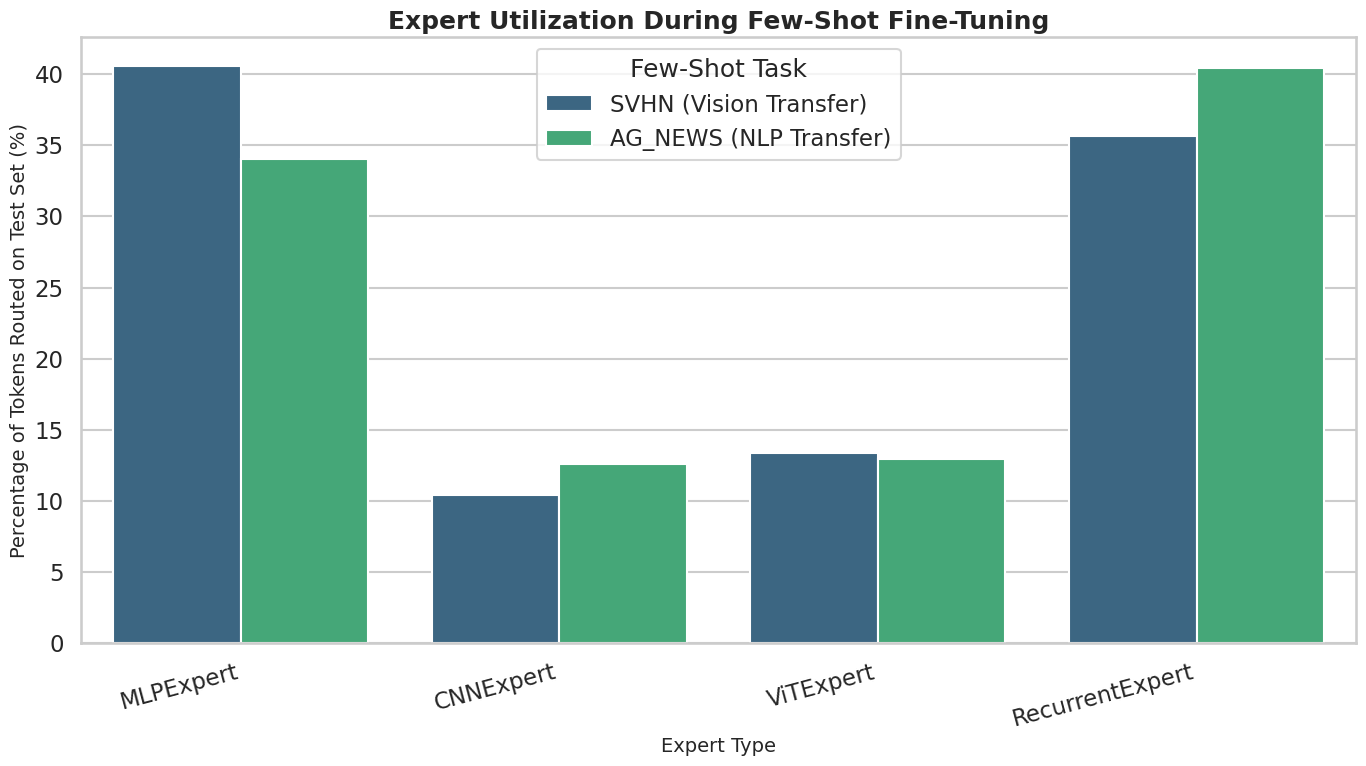

In [ ]:

def create_k_shot_loader(full_dataset, k_shot, num_classes, collate_fn=None):
    """Creates a balanced k-shot subset DataLoader."""
    try: targets = full_dataset.labels
    except AttributeError: targets = full_dataset.targets
    class_indices=[[] for _ in range(num_classes)];
    for i,label in enumerate(targets): class_indices[label].append(i)
    k_shot_indices=[]
    for indices in class_indices:
        k_shot_per_class=min(k_shot,len(indices))
        if k_shot_per_class > 0: k_shot_indices.extend(np.random.choice(indices, k_shot_per_class, replace=False))
    return DataLoader(Subset(full_dataset, k_shot_indices), batch_size=16, shuffle=True, collate_fn=collate_fn)

def run_few_shot_experiment(model, k_shot_loader, test_loader):
    """
    Fine-tunes a model and then analyzes its expert utilization on the test set.
    """
    model.to(DEVICE)
    print("Fine-tuning router and head...")
    for p in model.dmmoe_layer.experts.parameters(): p.requires_grad = False
    params_to_train = list(model.encoder.parameters()) + list(model.dmmoe_layer.router.parameters()) + list(model.head.parameters())
    optimizer = optim.AdamW(params_to_train, lr=1e-4)

    # Training Loop
    for epoch in range(15):
        model.train()
        for data, labels in k_shot_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE); optimizer.zero_grad()
            outputs = model(data); loss = F.cross_entropy(outputs, labels);
            loss.backward(); optimizer.step()

    # Analysis Loop
    model.eval(); correct, total = 0, 0
    num_experts = len(model.dmmoe_layer.experts)
    expert_counts = torch.zeros(num_experts, device=DEVICE)
    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Analyzing Test Set"):
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            # Use the model's built-in analysis flag
            outputs, expert_indices = model(data, return_indices=True)
            _, p = torch.max(outputs.data, 1)
            total += labels.size(0); correct += (p == labels).sum().item()
            expert_counts.add_(torch.bincount(expert_indices.flatten(), minlength=num_experts))

    accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {accuracy:.2f}%")
    return accuracy, expert_counts.cpu().numpy()



# 1. SVHN Experiment
print("\n--- Starting PRE-TRAINED Few-Shot Experiment on SVHN (Vision) ---")
svhn_transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
svhn_train_full = datasets.SVHN(root='./data', split='train', download=True, transform=svhn_transform)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)
svhn_k_shot_loader = create_k_shot_loader(svhn_train_full, k_shot=K_SHOT, num_classes=10)
svhn_test_loader = DataLoader(svhn_test, batch_size=128)

vision_encoder_pt = PatchEncoder(d_model=D_MODEL)
pretrained_vision_model = AdaptableDMMoE(vision_encoder_pt, num_classes=10, d_model=D_MODEL)
vision_weights_path = os.path.join(MODEL_SAVE_PATH, "DMMoE_CIFAR10_best.pth")
svhn_utilization = None
try:
    pretrained_vision_model.load_state_dict(torch.load(vision_weights_path), strict=False)
    print("Successfully loaded pre-trained CIFAR-10 weights.")
    _, svhn_utilization = run_few_shot_experiment(pretrained_vision_model, svhn_k_shot_loader, svhn_test_loader)
except Exception as e:
    print(f"Could not load vision weights, skipping experiment: {e}")

# 2. AG_NEWS Experiment
print("\n--- Starting PRE-TRAINED Few-Shot Experiment on AG_NEWS (NLP) ---")
nlp_encoder_pt = TextEmbeddingEncoder(AG_NEWS_VOCAB_SIZE, D_MODEL, ag_news_vocab['<pad>'])
pretrained_nlp_model = AdaptableDMMoE(nlp_encoder_pt, num_classes=4, d_model=D_MODEL)
nlp_weights_path = os.path.join(MODEL_SAVE_PATH, "DMMoE_AG_NEWS_best.pth")
ag_news_utilization = None
try:
    pretrained_nlp_model.load_state_dict(torch.load(nlp_weights_path), strict=False)
    print("Successfully loaded pre-trained AG_NEWS weights.")
    ag_news_k_shot_loader_pt = create_k_shot_loader(ag_train_ds, k_shot=K_SHOT, num_classes=4, collate_fn=collate_nlp)
    ag_news_test_loader_pt = DataLoader(ag_test_ds, batch_size=128, collate_fn=collate_nlp)
    _, ag_news_utilization = run_few_shot_experiment(pretrained_nlp_model, ag_news_k_shot_loader_pt, ag_news_test_loader_pt)
except Exception as e:
    print(f"Could not load NLP weights, skipping experiment: {e}")

# 3. Visualization
if svhn_utilization is not None and ag_news_utilization is not None:
    print("\n--- Generating Final Visualization ---")
    expert_names = ['MLPExpert', 'CNNExpert', 'ViTExpert', 'RecurrentExpert']
    util_data = {
        'Task': ['SVHN (Vision Transfer)'] * 4 + ['AG_NEWS (NLP Transfer)'] * 4,
        'Expert': expert_names * 2,
        'Tokens Routed': np.concatenate([svhn_utilization, ag_news_utilization])
    }
    util_df = pd.DataFrame(util_data)
    util_df['Percentage'] = 100 * util_df['Tokens Routed'] / util_df.groupby('Task')['Tokens Routed'].transform('sum')
    plt.figure(figsize=(14, 8)); sns.set_theme(style="whitegrid", context="talk")
    ax = sns.barplot(data=util_df, x='Expert', y='Percentage', hue='Task', palette='viridis')
    plt.title('Expert Utilization During Few-Shot Fine-Tuning', fontsize=18, weight='bold')
    plt.xlabel('Expert Type', fontsize=14); plt.ylabel('Percentage of Tokens Routed on Test Set (%)', fontsize=14)
    plt.xticks(rotation=15, ha="right"); plt.legend(title='Few-Shot Task'); plt.tight_layout()
    plt.savefig('figure_5_few_shot_utilization.png', dpi=300); plt.show()